In [ ]:
!pip install transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
#from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from PIL import Image
import requests
from io import BytesIO
from openpyxl import load_workbook
from sys import stdout
from sklearn.metrics import classification_report
from keras.preprocessing import image
import tensorflow as tf

DATA

In [6]:
wb = load_workbook(filename='/content/drive/MyDrive/Patent Classification/Dataset_Final.xlsx')
ws = wb.get_active_sheet() # ws is now an IterableWorksheet

# iterate thru all cells and if hyperlink found attempt modification of cell
for row in ws.rows:
    for cell in row:
        try:
            if len(cell.hyperlink.target)  > 0:
              if cell.value == 'View Image':
                cell.value = "".join([cell.hyperlink.target])
                # Join cell.value and hyperlink target into string (optionally just assign the hyperlink.target to the cell.value
        except:
            pass

# save workbook to temp .xlsx (I could not manage to read from buffer...) .
wb.save("temp.xlsx")

# read with pandas 
df = pd.read_excel("temp.xlsx")
df= df.dropna(axis = 0, how = 'any')
df.drop('CL', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_active_sheet (Use the .active property).
  


,PN,Labels,TI,FCL,AB,IMG
0,US6025187,Process,[EN] COMBINATIONS OF BACILLUS AND LACTOBACILLU...,[EN] 1. A process for converting an organic ni...,[EN] Bacterial complexes are provided which ma...,https://images.patbase.net/phpimg/?id=US602518...
1,US5897993,Method,[EN] METHOD OF DETERMINING THE NUMBER OF BACTE...,[EN] 1. A method of determining the number of ...,[EN] PCT No. PCT/JP96/00815 Sec. 371 Date Aug....,https://images.patbase.net/phpimg/?id=US589799...
2,US5955070,Novel Strain,[EN] INOCULATION BY GEOTRICHUM CANDIDUM DURING...,[EN] 1. An isolated strain of Geotrichum candi...,[EN] PCT No. PCT/FR96/00621 Sec. 371 Date Jan....,https://images.patbase.net/phpimg/?id=US595507...
3,US5686276,Process,[EN] BIOCONVERSION OF A FERMENTABLE CARBON SOU...,[EN] 1. A process comprising the bioconversion...,[EN] A process is provided for the bioconversi...,https://images.patbase.net/phpimg/?id=US568627...
4,US6428767,Method,[EN] METHOD FOR IDENTIFYING THE SOURCE OF CARB...,[EN] 1. A method for identifying the presence ...,[EN] A new polypropylene terephthalate composi...,https://images.patbase.net/phpimg/?id=US642876...
...,...,...,...,...,...,...
2395,US2021162029,Method,[EN] COMPOSITIONS AND METHODS FOR TREATMENT OR...,[EN] 1. A method of treating or preventing a s...,"[EN] The present disclosure provides, inter al...",https://images.patbase.net/phpimg/?id=US202116...
2396,US2021275612,Method,[EN] METHOD FOR ALLEVIATING INFLAMMATION-RELAT...,[EN] 1. A method for alleviating an inflammati...,[EN] Disclosed herein is a method for alleviat...,https://images.patbase.net/phpimg/?id=US202127...
2397,US2021401908,Composition,[EN] COMPOSITION FOR PROMOTING DEFECATION AND ...,[EN] 1. A composition for promoting defecation...,[EN] The present invention provides a composit...,https://images.patbase.net/phpimg/?id=US202140...
2398,US2021393706,Novel Strain,[EN] LACTOBACILLUS PARACASEI AO356 STRAIN HAVI...,[EN] 1. A Lactobacillus paracasei AO356 strain...,[EN] A novel Lactobacillus paracasei AO356 str...,https://images.patbase.net/phpimg/?id=US202139...


In [7]:
df2 = pd.read_csv("/content/drive/MyDrive/Patent Classification/datanr.csv")
df2 = df2.dropna(axis = 0, how = 'any')
df2.reset_index(drop=True, inplace=True)
df2['PN'] = df2['doc']
df2['Labels'] = df2['label']
df2['TI'] = df2['title']
df2['FCL'] = df2['claim']
df2['AB'] = df2['abstract']
df2['IMG'] = df2['image']

df2 = df2[['PN','Labels','TI','FCL','AB','IMG']]
df2 = df2[df2.IMG!='[]']
df2.reset_index(drop=True, inplace=True)
df2

,PN,Labels,TI,FCL,AB,IMG
0,US10165683,nr,Apparatus and methods for via connection with ...,An apparatus comprising:\na printed circuit b...,Apparatuses and methods including conductive v...,"['""https://patentimages.storage.googleapis.com..."
1,US10645799,nr,High-frequency and high-transmission speed FPC...,A high-frequency and high-transmission speed ...,A high-frequency and high-transmission speed F...,"['""https://patentimages.storage.googleapis.com..."
2,US10816856,nr,"Photo-alignment material, liquid crystal displ...",A manufacturing method for liquid crystal dis...,The present disclosure relates to a photo-alig...,"['""https://patentimages.storage.googleapis.com..."
3,US11066738,nr,Mask plates and display panels,"A mask plate for fabricating a display panel,...",The present application relates to a display p...,"['""https://patentimages.storage.googleapis.com..."
4,US2020260676,nr,Interspecific Hybrid Plant Resulting from a Cr...,. An interspecific hybrid plant derived from a...,The present invention relates to a hybrid betw...,"['""https://patentimages.storage.googleapis.com..."
...,...,...,...,...,...,...
1543,US11226862,nr,Surface bearing coded data,. A surface bearing machine-readable coded dat...,A surface bearing machine-readable coded data ...,"['""https://patentimages.storage.googleapis.com..."
1544,US11227516,nr,DC brushless motor drive circuit with speed va...,. A DC brushless motor drive circuit with spee...,"For the present invention, under various runni...","['""https://patentimages.storage.googleapis.com..."
1545,US11229138,nr,"Optical-signal processing apparatus, optical t...",. An optical-signal processing apparatus compr...,In an optical network system: control light is...,"['""https://patentimages.storage.googleapis.com..."
1546,US11224411,nr,Mutant tRNA for Introducing Unnatural Amino Ac...,. A mutant tRNA for tryptophan which pairs wit...,It is an objective of the present invention to...,"['""https://patentimages.storage.googleapis.com..."


In [8]:
aa = df2.IMG.values
bb = []
for a in aa:
  b = a.split('"')
  bb.append(b[1])

df2 = df2[['PN','Labels','TI','FCL','AB']]
df2['IMG'] = bb
df2 = df2[['PN','Labels','TI','FCL','AB','IMG']]
df2

,PN,Labels,TI,FCL,AB,IMG
0,US10165683,nr,Apparatus and methods for via connection with ...,An apparatus comprising:\na printed circuit b...,Apparatuses and methods including conductive v...,https://patentimages.storage.googleapis.com/39...
1,US10645799,nr,High-frequency and high-transmission speed FPC...,A high-frequency and high-transmission speed ...,A high-frequency and high-transmission speed F...,https://patentimages.storage.googleapis.com/9d...
2,US10816856,nr,"Photo-alignment material, liquid crystal displ...",A manufacturing method for liquid crystal dis...,The present disclosure relates to a photo-alig...,https://patentimages.storage.googleapis.com/5f...
3,US11066738,nr,Mask plates and display panels,"A mask plate for fabricating a display panel,...",The present application relates to a display p...,https://patentimages.storage.googleapis.com/e8...
4,US2020260676,nr,Interspecific Hybrid Plant Resulting from a Cr...,. An interspecific hybrid plant derived from a...,The present invention relates to a hybrid betw...,https://patentimages.storage.googleapis.com/b9...
...,...,...,...,...,...,...
1543,US11226862,nr,Surface bearing coded data,. A surface bearing machine-readable coded dat...,A surface bearing machine-readable coded data ...,https://patentimages.storage.googleapis.com/00...
1544,US11227516,nr,DC brushless motor drive circuit with speed va...,. A DC brushless motor drive circuit with spee...,"For the present invention, under various runni...",https://patentimages.storage.googleapis.com/e9...
1545,US11229138,nr,"Optical-signal processing apparatus, optical t...",. An optical-signal processing apparatus compr...,In an optical network system: control light is...,https://patentimages.storage.googleapis.com/0e...
1546,US11224411,nr,Mutant tRNA for Introducing Unnatural Amino Ac...,. A mutant tRNA for tryptophan which pairs wit...,It is an objective of the present invention to...,https://patentimages.storage.googleapis.com/f6...


In [9]:
df3 = pd.concat([df,df2])
df3.reset_index(drop=True, inplace=True)
df3['label'] = df3['Labels'].str.lower()
df3 = df3[['PN','TI','FCL','AB','IMG','label']]

sentences = []
titles = df3.TI.values
abstracts = df3.AB.values
claims = df3.FCL.values
for i in range (len(df3)):
  sentence = f"title:{titles[i][:150]} , claim:{claims[i][:150]}"
  sentence = sentence[:512]
  sentences.append(sentence)
sentences = np.array(sentences)
df3['sentence'] = sentences
df3.at[628, 'label'] = 'novel molecule'
print(f"Value counts for each class:\n\n{df3.label.value_counts()}\n")

Value counts for each class:

nr                1548
method             991
composition        382
process            326
product            263
novel strain       229
novel molecule     209
Name: label, dtype: int64



In [10]:
df3

,PN,TI,FCL,AB,IMG,label,sentence
0,US6025187,[EN] COMBINATIONS OF BACILLUS AND LACTOBACILLU...,[EN] 1. A process for converting an organic ni...,[EN] Bacterial complexes are provided which ma...,https://images.patbase.net/phpimg/?id=US602518...,process,title:[EN] COMBINATIONS OF BACILLUS AND LACTOB...
1,US5897993,[EN] METHOD OF DETERMINING THE NUMBER OF BACTE...,[EN] 1. A method of determining the number of ...,[EN] PCT No. PCT/JP96/00815 Sec. 371 Date Aug....,https://images.patbase.net/phpimg/?id=US589799...,method,title:[EN] METHOD OF DETERMINING THE NUMBER OF...
2,US5955070,[EN] INOCULATION BY GEOTRICHUM CANDIDUM DURING...,[EN] 1. An isolated strain of Geotrichum candi...,[EN] PCT No. PCT/FR96/00621 Sec. 371 Date Jan....,https://images.patbase.net/phpimg/?id=US595507...,novel strain,title:[EN] INOCULATION BY GEOTRICHUM CANDIDUM ...
3,US5686276,[EN] BIOCONVERSION OF A FERMENTABLE CARBON SOU...,[EN] 1. A process comprising the bioconversion...,[EN] A process is provided for the bioconversi...,https://images.patbase.net/phpimg/?id=US568627...,process,title:[EN] BIOCONVERSION OF A FERMENTABLE CARB...
4,US6428767,[EN] METHOD FOR IDENTIFYING THE SOURCE OF CARB...,[EN] 1. A method for identifying the presence ...,[EN] A new polypropylene terephthalate composi...,https://images.patbase.net/phpimg/?id=US642876...,method,title:[EN] METHOD FOR IDENTIFYING THE SOURCE O...
...,...,...,...,...,...,...,...
3943,US11226862,Surface bearing coded data,. A surface bearing machine-readable coded dat...,A surface bearing machine-readable coded data ...,https://patentimages.storage.googleapis.com/00...,nr,"title:Surface bearing coded data , claim:. A s..."
3944,US11227516,DC brushless motor drive circuit with speed va...,. A DC brushless motor drive circuit with spee...,"For the present invention, under various runni...",https://patentimages.storage.googleapis.com/e9...,nr,title:DC brushless motor drive circuit with sp...
3945,US11229138,"Optical-signal processing apparatus, optical t...",. An optical-signal processing apparatus compr...,In an optical network system: control light is...,https://patentimages.storage.googleapis.com/0e...,nr,"title:Optical-signal processing apparatus, opt..."
3946,US11224411,Mutant tRNA for Introducing Unnatural Amino Ac...,. A mutant tRNA for tryptophan which pairs wit...,It is an objective of the present invention to...,https://patentimages.storage.googleapis.com/f6...,nr,title:Mutant tRNA for Introducing Unnatural Am...


MODEL

TEXT-MODEL

In [ ]:
class pipeLine:

    def __init__(self,name):

        self.model_name = name
        self.model = pipeline('text-classification', model=self.model_name, tokenizer=self.model_name)
        self.label_dict = {"LABEL_0":"method", "LABEL_1":"composition", "LABEL_2":"process", 
                           "LABEL_3":"product", "LABEL_4":"novel molecule","LABEL_5":"novel strain","LABEL_6":"nr"}

    def predict(self,sentence):

        prediction = self.model(sentence)
        prediction = prediction[0]
        label = self.label_dict[prediction['label']]
        probability = prediction['score']

        return label,probability

In [ ]:
name = "fadhilarkan/patentclassification"
model_tb = pipeLine(name)

Downloading:   0%|          | 0.00/921 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
texts = df3.sentence.values
text_labels = df3.label.values

predictions_text = []
predictions_prob_text = []
for i,text in enumerate(texts):
  stdout.write("\r%d" % i)
  stdout.flush()
  #text = [text[0]+text[1]]
  prediction = model_tb.predict(text[:512])
  prob = prediction[1]
  prediction = prediction[0]

  predictions_text.append(prediction)
  predictions_prob_text.append(prob)

3947

In [ ]:
target_names = ["composition", "method", "novel molecule","novel strain","nr", "process", "product"]

def compute_score(y_true, y_pred):

  print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
compute_score(text_labels,predictions_text)

                precision    recall  f1-score   support

   composition       0.95      0.96      0.95       382
        method       0.99      0.99      0.99       991
novel molecule       0.96      0.95      0.95       209
  novel strain       0.97      0.95      0.96       229
            nr       1.00      1.00      1.00      1548
       process       0.97      0.95      0.96       326
       product       0.96      0.97      0.96       263

      accuracy                           0.98      3948
     macro avg       0.97      0.97      0.97      3948
  weighted avg       0.98      0.98      0.98      3948



IMAGE-MODEL

In [24]:
def pred(model,urls):
  preds = []
  probs = []
  dict_lbl = {0: "method",
              1: "novel molecule",
              2: "novel strain",
              3: "process",
              4: "product"
              }
  for i,url in enumerate(urls):
    stdout.write("\r%d" % i)
    stdout.flush()

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150,150))
    #img = image.load_img(path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.

    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)
    prob = np.max(classes)
    classes = np.argmax(classes)
    classes = dict_lbl[classes]
    print(i,classes)

    preds.append(classes)
    probs.append(prob)

  return np.array(preds),np.array(probs)

In [17]:
model_path = "/content/drive/MyDrive/Patent Classification/image based/patent-classification_bestontraining.h5"
model_ib = tf.keras.models.load_model(model_path)
urls = df3.IMG.values

In [29]:
urls[:1000]

array(['https://images.patbase.net/phpimg/?id=US6025187_A&file=US6025187_A.png',
       'https://images.patbase.net/phpimg/?id=US5897993_A&file=US5897993_A.png',
       'https://images.patbase.net/phpimg/?id=US5955070_A&file=US5955070_A.png',
       'https://images.patbase.net/phpimg/?id=US5686276_A&file=US5686276_A.png',
       'https://images.patbase.net/phpimg/?id=US6428767_BA&file=US6428767_BA.png',
       'https://images.patbase.net/phpimg/?id=US7135309_BA&file=US7135309_BA.png',
       'https://images.patbase.net/phpimg/?id=US5681728_A&file=US5681728_A.png',
       'https://images.patbase.net/phpimg/?id=US6187990_BA&file=US6187990_BA.png',
       'https://images.patbase.net/phpimg/?id=US5747277_A&file=US5747277_A.png',
       'https://images.patbase.net/phpimg/?id=US6054262_A&file=US6054262_A.png',
       'https://images.patbase.net/phpimg/?id=US6221823_BA&file=US6221823_BA.png',
       'https://images.patbase.net/phpimg/?id=US5627045_A&file=US5627045_A.png',
       'https://imag

In [25]:
predictions_img,predictions_prob_img = pred(model_ib,urls)

00 novel molecule
11 product
22 method
33 process
44 product
55 process
66 method
77 product
88 novel molecule
99 product
1010 process
1111 product
1212 product
1313 product
1414 method
1515 method
1616 product
1717 method
1818 novel molecule
1919 method
2020 product
2121 product
2222 method
2323 product
2424 product
2525 product
2626 process
2727 process
2828 product
2929 process
3030 novel strain
3131 novel strain
3232 product
3333 product
3434 method
3535 product
3636 novel strain
3737 product
3838 product
3939 method
4040 method
4141 method
4242 product
4343 process
4444 process
4545 process
4646 process
4747 product
4848 product
4949 method
5050 product
5151 product
5252 product
5353 method
5454 product
5555 novel molecule
5656 product
5757 product
58

KeyboardInterrupt: ignored

In [ ]:
fordf = {"label":text_labels,"tb_pred":predictions_text,"tb_pred_prob":predictions_prob_text,"ib_pred":predictions_img,"ib_pred_prob":predictions_prob_img}
combined = pd.DataFrame(data=fordf)
combined.to_excel("/content/drive/MyDrive/Patent Classification/pred_results.xlsx")

In [ ]:
combined

,label,tb_pred,tb_pred_prob,ib_pred,ib_pred_prob
0,process,process,0.997413,novel molecule,0.999977
1,method,method,0.999089,product,0.955946
2,novel strain,novel strain,0.994035,method,0.863554
3,process,process,0.997845,process,0.454293
4,method,method,0.999073,product,0.995764
...,...,...,...,...,...
3943,nr,nr,0.999736,error,0.000000
3944,nr,nr,0.999741,error,0.000000
3945,nr,nr,0.999734,error,0.000000
3946,nr,nr,0.999695,error,0.000000


In [ ]:
pred_combined = pd.read_excel("/content/drive/MyDrive/Patent Classification/pred_results.xlsx")

In [ ]:
combined_preds = []
for i in range (len(pred_combined)):
  if (pred_combined.tb_pred[i]=='composition' or pred_combined.tb_pred[i]=='nr'):
    combined_pred = pred_combined.tb_pred[i]
  elif pred_combined.tb_pred_prob[i]>pred_combined.ib_pred_prob[i]:
    combined_pred = pred_combined.tb_pred[i]
  else :
    combined_pred = pred_combined.ib_pred[i]
  combined_preds.append(combined_pred)

In [ ]:
pred_combined['combined_pred'] = combined_preds

In [ ]:
pred_combined.to_excel("/content/drive/MyDrive/Patent Classification/pred_results_combined.xlsx")

In [ ]:
pred_combined = pd.read_excel("/content/drive/MyDrive/Patent Classification/pred_results_combined.xlsx")

combined_preds = []
text_labels = df3.label.values

for i in range (len(pred_combined)):
  if (pred_combined.tb_pred[i]=='composition' or pred_combined.tb_pred[i]=='nr'):
    combined_pred = pred_combined.tb_pred[i]
  elif pred_combined.tb_pred_prob[i]>pred_combined.ib_pred_prob[i]:
    combined_pred = pred_combined.tb_pred[i]
  else :
    combined_pred = pred_combined.ib_pred[i]
  combined_preds.append(combined_pred)

In [ ]:
pred_combined = pd.read_excel("/content/drive/MyDrive/Patent Classification/pred_results_combined.xlsx")

combined_preds = []
text_labels = df3.label.values
cls = ['novel molecule', 'novel strain', 'process', 'product']
for i in range (len(pred_combined)):
  if (pred_combined.tb_pred[i]=='composition' or pred_combined.tb_pred[i]=='nr'):
    combined_pred = pred_combined.tb_pred[i]
  if pred_combined.ib_pred[i] in cls:
    combined_pred = pred_combined.ib_pred[i]
  elif pred_combined.tb_pred_prob[i]>pred_combined.ib_pred_prob[i]:
    combined_pred = pred_combined.tb_pred[i]
  else :
    combined_pred = pred_combined.ib_pred[i]
  combined_preds.append(combined_pred)

In [ ]:
from sklearn.model_selection import train_test_split

Train_true, Test_true, Train_pred, Test_pred = train_test_split(text_labels,combined_preds, test_size=0.25, random_state=42)


In [ ]:
compute_score(Train_true,Train_pred)

                precision    recall  f1-score   support

   composition       0.95      0.14      0.25       289
        method       0.96      0.22      0.35       733
novel molecule       0.29      0.51      0.37       159
  novel strain       0.38      0.35      0.36       172
            nr       1.00      1.00      1.00      1185
       process       0.49      0.42      0.45       236
       product       0.19      0.94      0.31       187

      accuracy                           0.61      2961
     macro avg       0.61      0.51      0.44      2961
  weighted avg       0.82      0.61      0.61      2961



In [ ]:
compute_score(Test_true,Test_pred)

                precision    recall  f1-score   support

   composition       1.00      0.14      0.25        93
        method       0.98      0.25      0.40       258
novel molecule       0.26      0.48      0.33        50
  novel strain       0.31      0.26      0.28        57
            nr       1.00      1.00      1.00       363
       process       0.47      0.34      0.40        90
       product       0.21      0.95      0.35        76

      accuracy                           0.59       987
     macro avg       0.60      0.49      0.43       987
  weighted avg       0.81      0.59      0.59       987



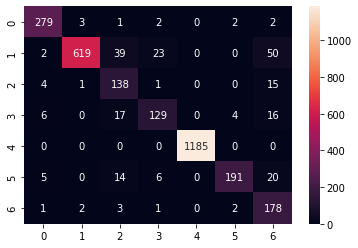

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(Train_true,Train_pred), annot = True, fmt="g")
plt.show()

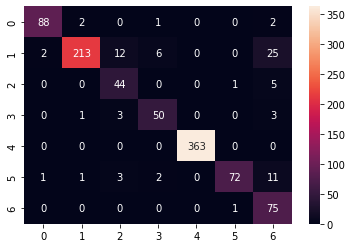

In [ ]:
sns.heatmap(confusion_matrix(Test_true,Test_pred), annot = True, fmt="g")
plt.show()